In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle
import os
import sys
import glob
from collections import OrderedDict
from tqdm import tqdm

In [38]:
sys.path.append('../../')
import compute_preprocessing

In [39]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [40]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output

In [41]:
import tensorflow as tf

In [42]:
import pugna.layers
import pugna.activations

In [43]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [44]:
def preload_amp(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing_1e4/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data_1e4/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data_1e4/amplitude.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e4/amp_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data_1e4/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params

# def preload_phase(data_dir):

#     pkl_filename = os.path.join(data_dir, "pre_processing_1e3/times_scaler.pkl")
#     with open(pkl_filename, 'rb') as file:
#         times_scaler = pickle.load(file)
    
    
#     times = np.load(os.path.join(data_dir, "training_data_1e3/times.npy"))
    
#     times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
#     ys_raw = np.load(os.path.join(data_dir, "training_data_1e3/phase.npy"))
#     ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e3/phase_preprocessing_params.npz"))
    
#     ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
#     coords = np.load(os.path.join(data_dir, "training_data_1e3/coords.npy"))
# #     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
#     return times, times_scaled, coords, ys_raw, ys, ys_processing_params

In [45]:
# mfiles = sorted(glob.glob("00*/model*"))
mfiles = sorted(glob.glob("009*/model*"))
print(mfiles)

models = OrderedDict()
for mfile in mfiles:
    key = mfile.split('/')[0]
    models[key] = tf.keras.models.load_model(mfile,
                                       custom_objects={'Mscale': pugna.layers.Mscale,
                                                       'Activation':tf.keras.layers.Activation,
                                                       'name':pugna.activations.s2relu})

['009/model.h5', '009_continue_001/model.h5']


In [46]:
models.keys()

odict_keys(['009', '009_continue_001'])

In [47]:
data_dir="/home/sebastian.khan/git/stk/ml/waveforms/april2021/3d-precession/upscale/"

In [48]:
times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_amp(data_dir=data_dir)
# times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_phase(data_dir=data_dir)

In [49]:
coords.shape

(3, 10000)

In [50]:
ys.shape

(10000, 1099)

In [51]:
times

array([-499.50438159, -499.00438159, -498.50438159, ...,   48.49561841,
         48.99561841,   49.49561841])

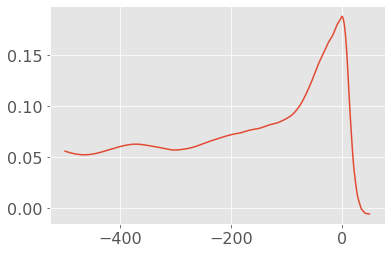

In [52]:
plt.figure()
plt.plot(times, ys[0])

In [53]:
def compare_models(index, ys_raw, preprocessing_params, coords, times_scaled, times, models, ylim=None, xlim=None):
    q = np.around(coords[0,index], 3)
    chi1 = np.around(coords[1,index], 3)
    theta1 = np.around(coords[2,index], 3)
    
    title = f"q = {q}, chi1 = {chi1}, theta1 = {theta1}"
    
    Xhat = compute_model_input(times_scaled, q, chi1, theta1)
    yhats = OrderedDict()
    for k, v in models.items():
        yhat = models[k].predict(Xhat).T
        
        yhats[k] = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
#         yhats[k] = yhat[0]
        
        
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(times, ys_raw[index], label='data')
    for k, v in yhats.items():
        plt.plot(times, v, label=k, ls='--')
    if xlim:
        plt.xlim(*xlim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
#     plt.yscale('log')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.subplot(2, 1, 2)
    for k, v in yhats.items():
#         plt.plot(times, 100*np.abs((v-ys_raw[index])/ys_raw[index]), label=f"% (data-{k})")
        plt.plot(times, (v-ys_raw[index]), label=f"% (data-{k})")
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
#     plt.ylim(-10, 10)
#     plt.yscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [54]:
np.where((coords[1] > 0.98) & (coords[2] > 1.3))

(array([  73,  160,  277,  485,  594,  681,  706,  852,  885,  945, 1066,
        1287, 1308, 1374, 1387, 1453, 1482, 1828, 1983, 2032, 2296, 2749,
        2837, 2897, 2904, 2984, 3325, 3421, 3431, 3476, 3518, 3990, 4102,
        4164, 4169, 4327, 4620, 4767, 4777, 5005, 5107, 5139, 5210, 5471,
        5477, 5618, 5845, 5859, 6459, 6622, 6809, 6940, 7014, 7064, 7572,
        7581, 7582, 7810, 7856, 8050, 8057, 8119, 8236, 8260, 8285, 8505,
        8552, 8553, 9110, 9159, 9406, 9635, 9994]),)

In [55]:
np.where((coords[1] > 0.98) & (coords[2] > 1.3) & (coords[2] < 1.6))

(array([1308, 1453, 1828, 2837, 2897, 3325, 3431, 5471, 7014, 7581, 7856,
        8057, 8285]),)

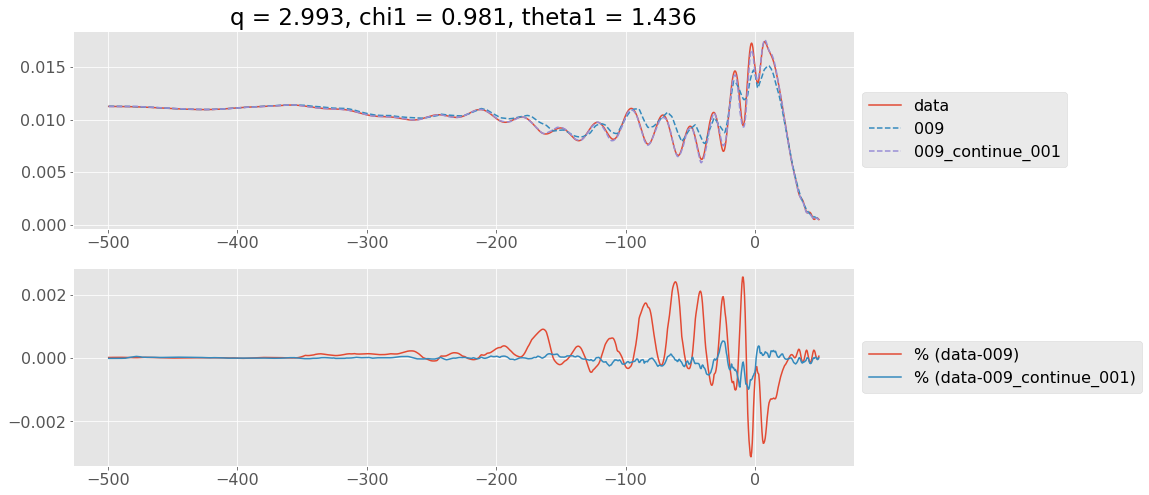

In [56]:
# compare_models(index=789, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
compare_models(index=1828, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

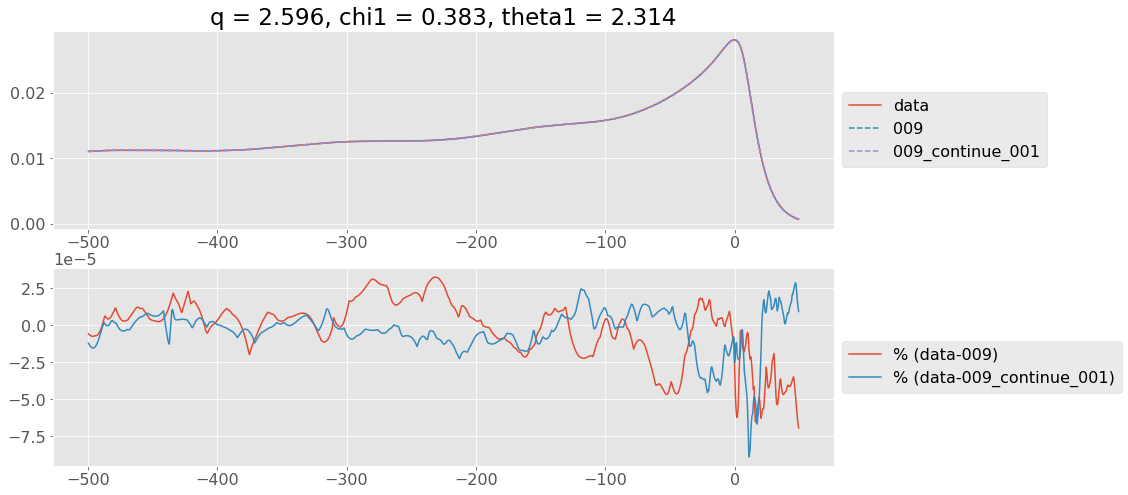

In [57]:
# compare_models(index=10, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
compare_models(index=10, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [58]:
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models={'005':models['005']})

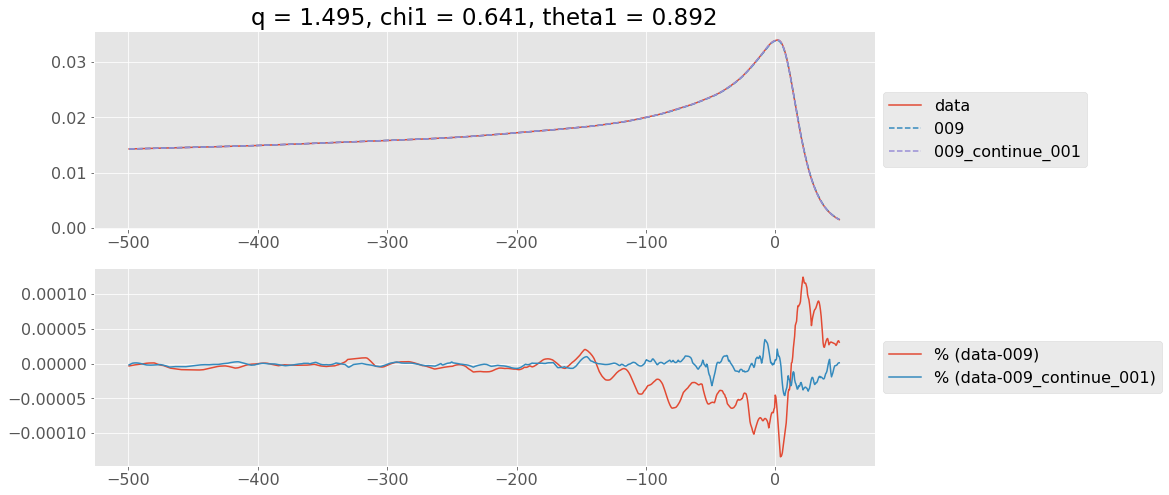

In [59]:
# compare_models(index=82, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
compare_models(index=82, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [60]:
# Xhat = convert_input_for_ann(times_scaled, *coords[:, :10])
# # Xhat = convert_input_for_ann(times_scaled, *coords)
# yhat = models['008'].predict(Xhat).T

In [61]:
# yhat.shape

In [62]:
def compute_errors(ys_raw, preprocessing_params, coords, times_scaled, times, models):
    
    n_cases = coords.shape[1]
#     max_loop = 10
    max_loop = n_cases
    
    yhats = OrderedDict()
    errors = OrderedDict()
    for k, v in models.items():
        
        if os.path.exists(f"errors_{k}.npy"):
            print("ALREADY CALCULATED LOADING DATA")
            errors[k] = np.load(f"errors_{k}.npy")
            continue
        
        print(f"working model: {k}")
        yhats[k] = np.zeros(shape=(n_cases, times_scaled.shape[0]))
        errors[k] = np.zeros(shape=(max_loop))

#         for index in tqdm(range(n_cases)):
        for index in tqdm(range(max_loop)):

            q = coords[0,index]
            chi1 = coords[1,index]
            theta1 = coords[2,index]

            Xhat = compute_model_input(times_scaled, q, chi1, theta1)
        
            yhat = models[k].predict(Xhat).T
            tt = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
            yhats[k][index] = tt
            
#             errors[k][index] = np.max(100*(ys_raw[index]-yhats[k][index])/ys_raw[index])
            errors[k][index] = np.max(np.abs(ys_raw[index]-yhats[k][index]))
            
        print("SAVING")
        np.save(f"errors_{k}.npy", errors[k])
        
    return errors

In [63]:
%%time
errors = compute_errors(ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
CPU times: user 2.45 ms, sys: 1.41 ms, total: 3.86 ms
Wall time: 3.31 ms


In [64]:
# errors['008'].shape

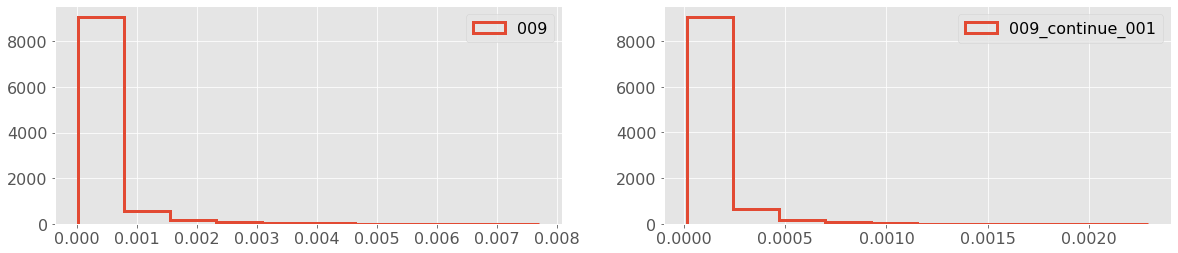

In [65]:
plt.figure(figsize=(20, 4))
for i,(k,v) in enumerate(errors.items()):
    plt.subplot(1, len(errors.keys()), i+1)
    plt.hist(np.abs(v), label=k, histtype='step', linewidth=3);
#     , density=True
    plt.legend()
# plt.xlim(0, 100)

In [66]:
max_idx = {}
for i,(k,v) in enumerate(errors.items()):
    max_value = np.max(np.abs(v))
    print(f"{k}: {max_value}")
    max_idx[k] = np.where(np.abs(v) == max_value)

009: 0.007705525675986733
009_continue_001: 0.0022888578936794256


In [67]:
max_idx

{'009': (array([5962]),), '009_continue_001': (array([1387]),)}

Text(0, 0.5, '$\\theta_1$')

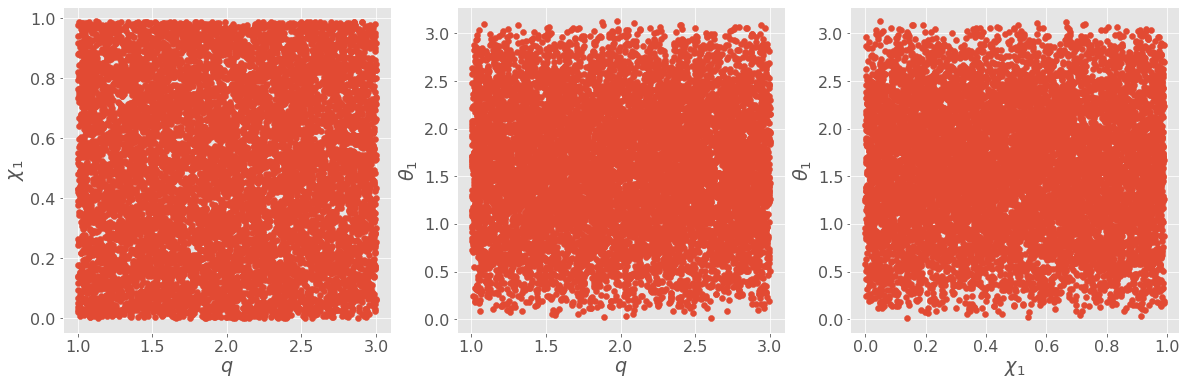

In [68]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1])
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2])
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2])
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

In [70]:
# plt.figure(figsize=(20, 6))
# plt.subplot(1, 3, 1)
# plt.scatter(coords[0], coords[1], c=errors['001'], cmap='viridis_r')
# plt.colorbar()
# plt.xlabel(r'$q$')
# plt.ylabel(r'$\chi_1$')
# plt.subplot(1, 3, 2)
# plt.scatter(coords[0], coords[2], c=errors['001'], cmap='viridis_r')
# plt.colorbar()
# plt.xlabel(r'$q$')
# plt.ylabel(r'$\theta_1$')
# plt.subplot(1, 3, 3)
# plt.scatter(coords[1], coords[2], c=errors['001'], cmap='viridis_r')
# plt.colorbar()
# plt.xlabel(r'$\chi_1$')
# plt.ylabel(r'$\theta_1$')

Text(0, 0.5, '$\\theta_1$')

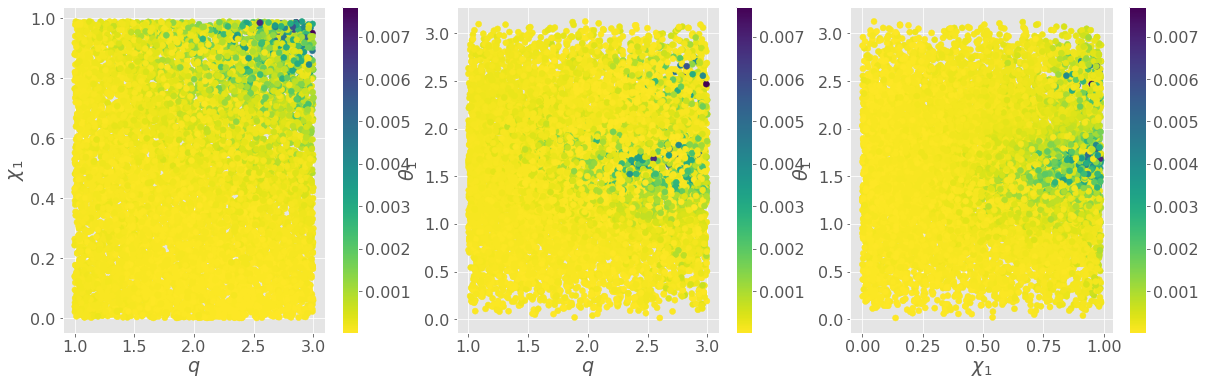

In [71]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1], c=errors['009'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2], c=errors['009'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2], c=errors['009'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

Text(0, 0.5, '$\\theta_1$')

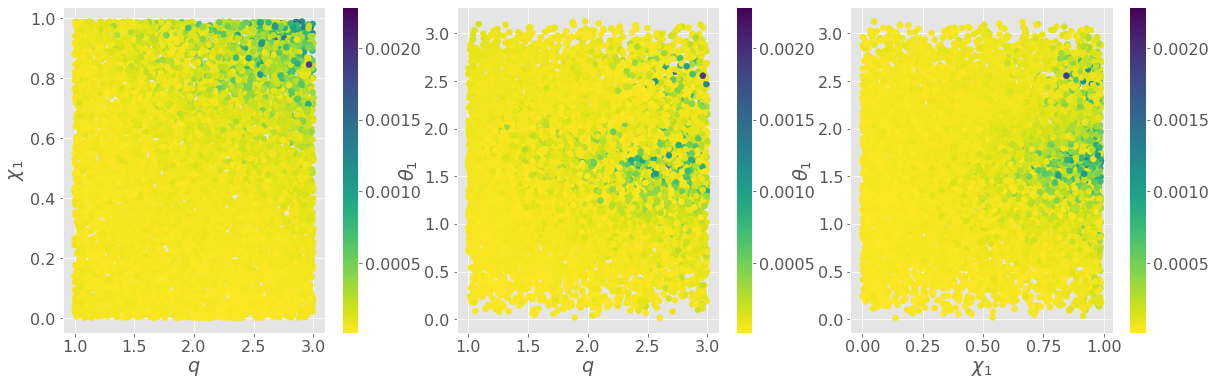

In [72]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1], c=errors['009_continue_001'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2], c=errors['009_continue_001'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2], c=errors['009_continue_001'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

In [73]:
worst_cases_values = np.flip(np.sort(np.abs(errors['009_continue_001'])))[:10]
# worst_cases_values = np.flip(np.sort(np.abs(errors['009_continue_001'])))[-10:]
worst_cases_idx = np.array([np.where(np.abs(errors['009_continue_001']) == w_c)[0][0] for w_c in worst_cases_values])

In [74]:
worst_cases_values

array([0.00228886, 0.00187462, 0.00181548, 0.00179257, 0.00157212,
       0.00150792, 0.00143361, 0.00142794, 0.00140769, 0.00137377])

In [75]:
worst_cases_idx

array([1387, 9968, 5477, 3961, 2890,  485, 2905, 1286, 4661, 1743])

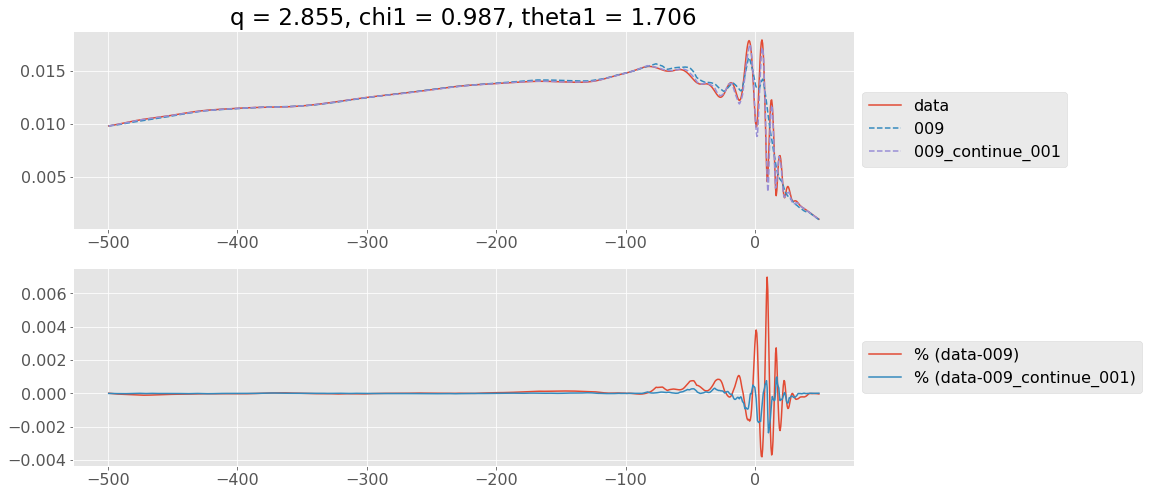

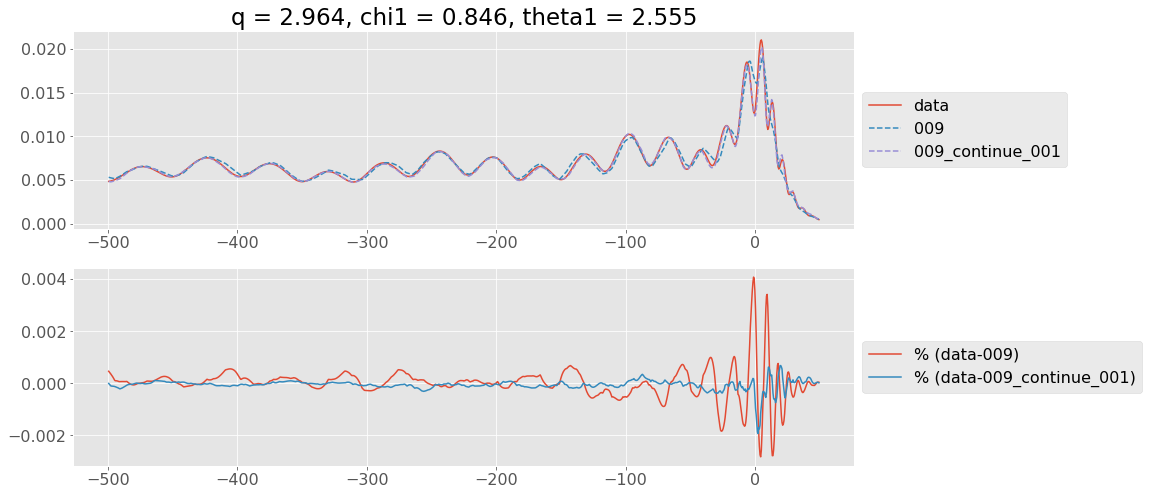

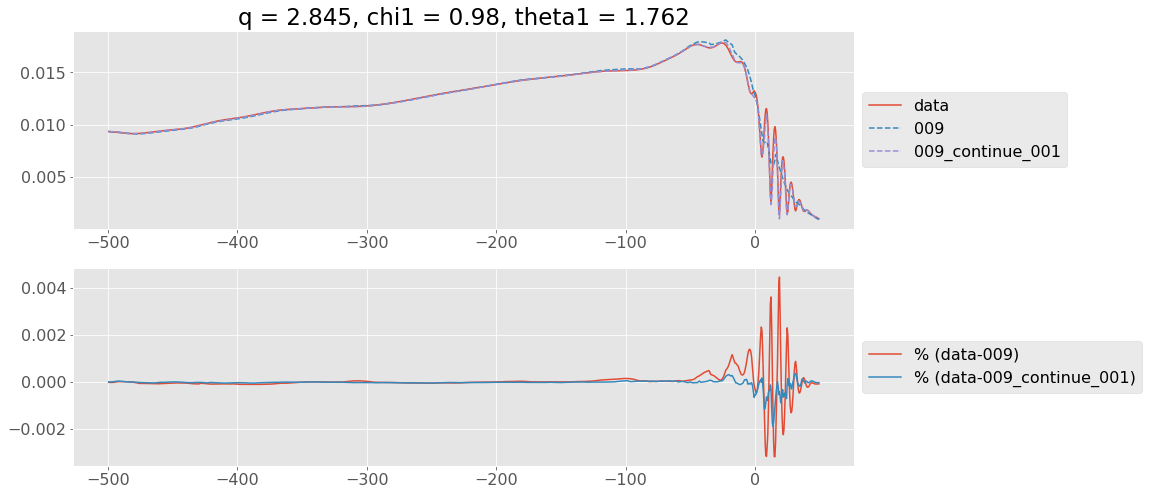

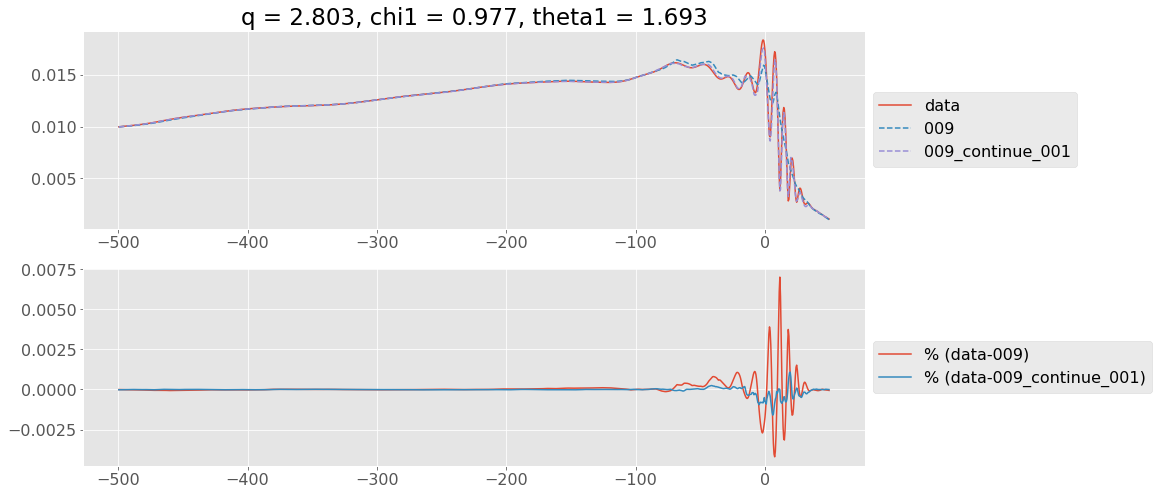

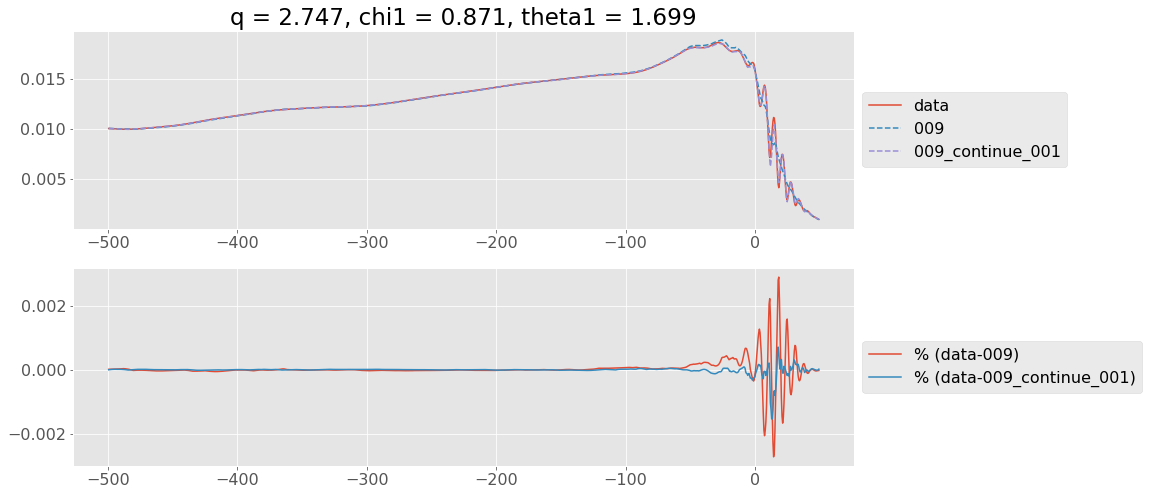

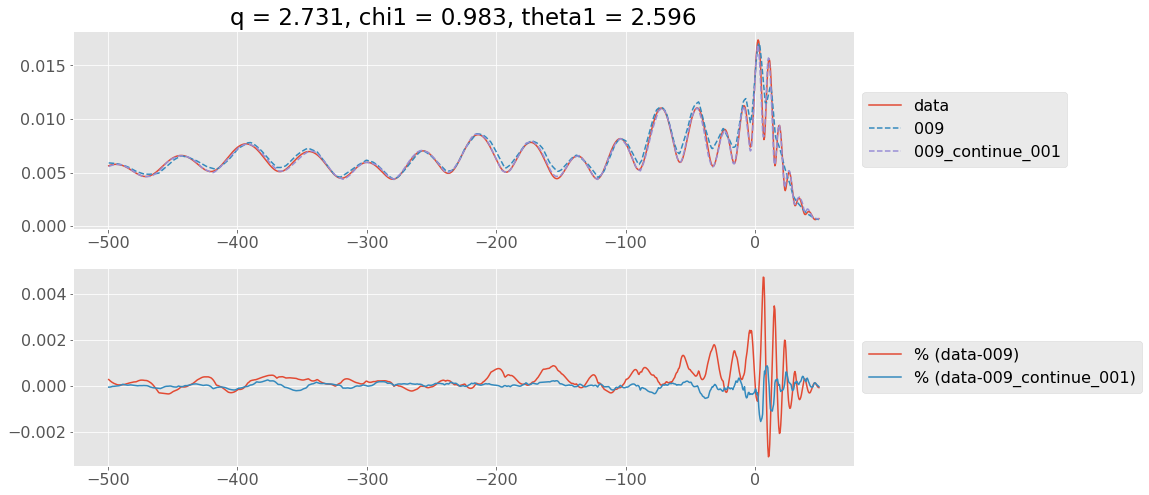

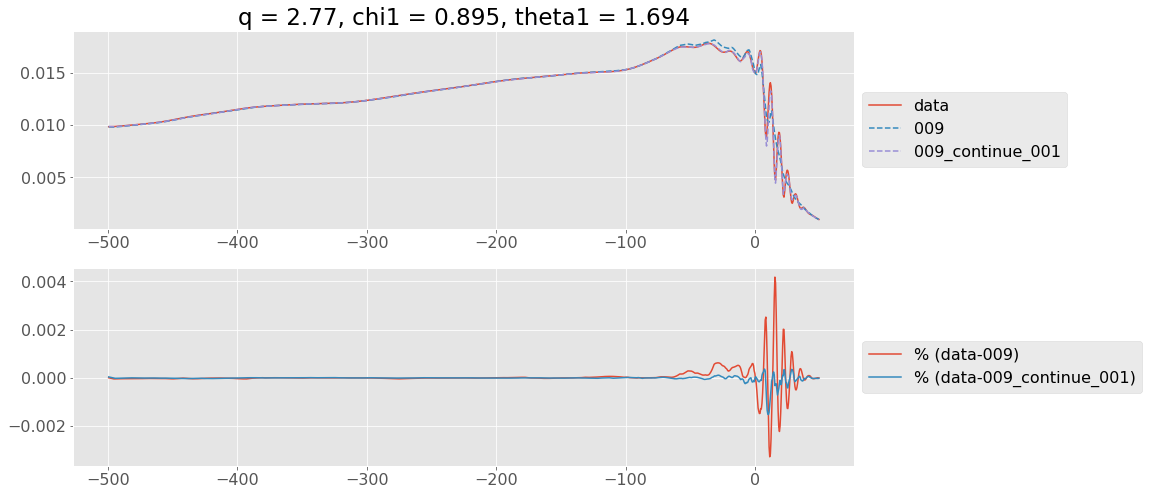

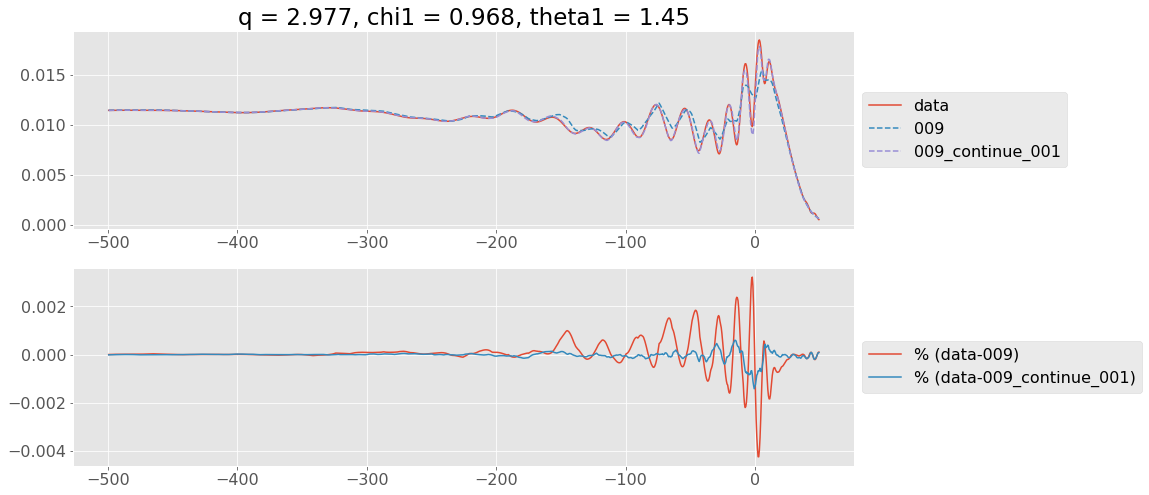

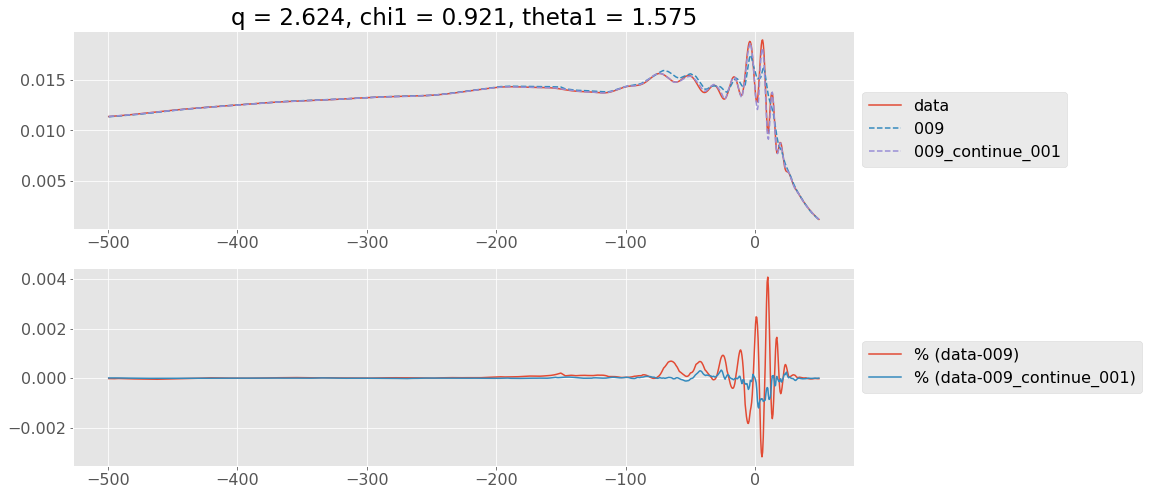

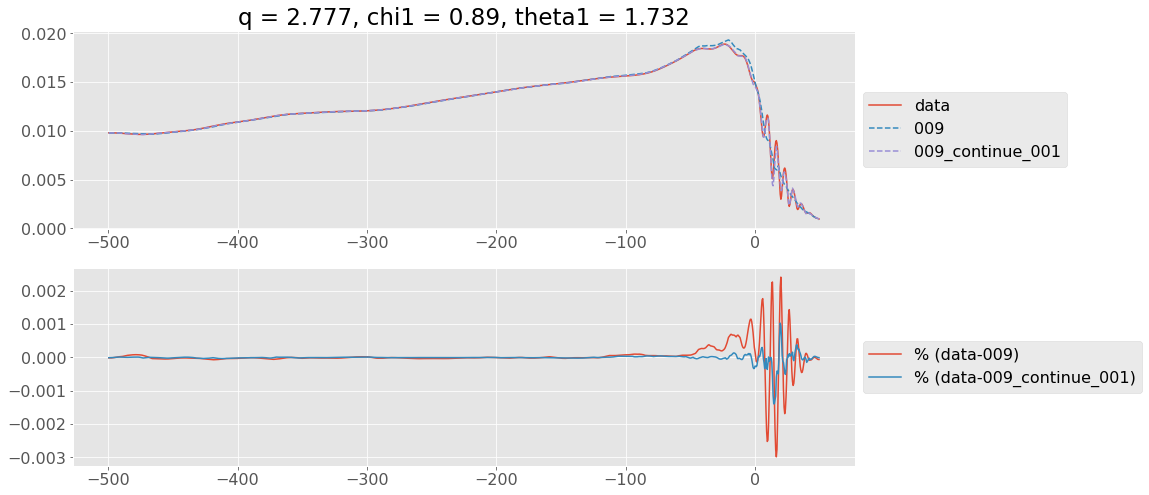

In [76]:
for index in worst_cases_idx:
    compare_models(index=index, ys_raw=ys_raw, preprocessing_params=ys_processing_params,
                   coords=coords, times_scaled=times_scaled, times=times, models={'009':models['009'], '009_continue_001':models['009_continue_001']})

In [ ]:
# smaller time resolution to fix ringdown?
# (theta, phi) - sky angles?
#    - try just theta = pi/2?
# go to much larger q to check - e.g. 6
# try v4PHM